# Exploring the different Logistic Mixed Model regressions which use the `hime.LogisticRegression` class as the `BaseEstimator`

In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.datasets import make_regression
# from sklearn.metrics import r2_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import session_info
import scipy

In [2]:
import statsmodels.api as sm
# import statsmodels.formula.api as smf

In [3]:
current_wd = os.getcwd()
os.chdir(current_wd.split("/notebook")[0])
# from hime.linear_model import LinearRegression, LassoRegression, RidgeRegression
from hime.multi_level_model import LogisticMixedRegression
os.chdir(current_wd)

In [4]:
session_info.show(write_req_file=False)

## Make X and y data

In [5]:
data = sm.datasets.get_rdataset('dietox', 'geepack').data

In [6]:
data = data.assign(Weight_bin = (data["Weight"] > 40).astype(int))

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [7]:
data.head()

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time,Weight_bin
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1,0
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2,0
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3,0
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4,1
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5,1


In [8]:
df_train = data.sample(frac=0.8, random_state=69420)
df_test = data.drop(df_train.index)

In [9]:
df_train.shape, df_test.shape

((689, 9), (172, 9))

## Fit the romeo LinearMixedRegression

In [10]:
mixed_dict = {"target": "Weight_bin",
"fixed_effect": "Time",
"grouping_var": "Pig",
"random_slope": "Time"}

In [11]:
def unpack_X(df, fixed_effect, grouping_var, random_slope, target):
    X=df[fixed_effect]
    u=df[grouping_var].unique()
    random_slope_array=df[random_slope]
    y=df[target]
    return X, y, u, random_slope

In [12]:
# unpack_X(df_train, **mixed_dict)

In [13]:
reg = LogisticMixedRegression(fit_intercept=True,
                      normalize=True).fit(X=data[[mixed_dict["fixed_effect"], mixed_dict["grouping_var"]]],
                                         y=data[mixed_dict["target"]],
                                          verbose=False,
                                         kwargs=mixed_dict)

In [14]:
reg.u

array([4601, 4602, 4603, 4605, 4641, 4643, 4645, 4756, 4757, 4759, 4760,
       4813, 4814, 4815, 4817, 4854, 4856, 4857, 4858, 5389, 5392, 5497,
       5500, 5501, 5502, 5524, 5527, 5528, 5578, 5581, 5582, 5850, 5851,
       5852, 5862, 5865, 5866, 6055, 6056, 6057, 6058, 6207, 6208, 6211,
       6284, 6287, 6288, 6430, 6432, 6433, 6909, 6910, 6912, 8049, 8050,
       8051, 8053, 8139, 8141, 8142, 8144, 8191, 8192, 8193, 8195, 8269,
       8270, 8271, 8273, 8437, 8439, 8442])

In [15]:
reg.intercept_

144.81219887399047

In [16]:
reg.summary_

,coef
intercept,144.812199
Time,30.775826
4601,-252.589299
4602,-252.589299
4603,-252.589299
...,...
8271,-252.589299
8273,-252.589299
8437,-252.589299
8439,-252.589299


In [17]:
# reg.fit_evaluation_.round(3)

In [18]:
intercept = reg.intercept_
coefs = reg.coef_

## Plot the target vs the fitted values

In [19]:
reg.fitted_values

0     -221.813473
1     -191.037647
2     -160.261821
3     -129.485994
4      -98.710168
          ...    
856    -36.893851
857     -6.118025
858     24.657801
859     55.433627
860     86.209454
Length: 861, dtype: float64

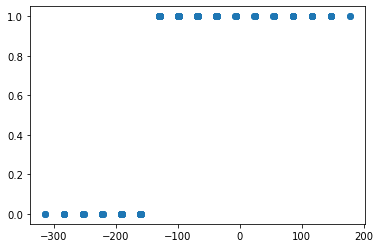

In [20]:
_ = plt.scatter(reg.fitted_values, data[mixed_dict["target"]])

In [22]:
reg.fitted_values

0     -221.813473
1     -191.037647
2     -160.261821
3     -129.485994
4      -98.710168
          ...    
856    -36.893851
857     -6.118025
858     24.657801
859     55.433627
860     86.209454
Length: 861, dtype: float64

In [23]:
def sigmoid(z):
    # Note it might be necessary to replace the np.exp with casadi version
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [25]:
sigmoid(reg.fitted_values).round(1)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
856    0.0
857    0.0
858    1.0
859    1.0
860    1.0
Length: 861, dtype: float64

In [26]:
c_mat = confusion_matrix(sigmoid(reg.fitted_values).round(1), data[mixed_dict["target"]])

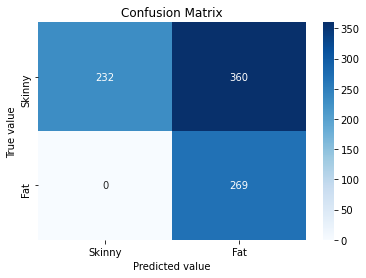

In [29]:
cmap='Blues'
categories=["Skinny", "Fat"]

_ = sns.heatmap(c_mat, 
                annot=True,            
                fmt="",
                cmap=cmap,
#                 cbar=cbar,
                xticklabels=categories,
                yticklabels=categories
               )
_ = plt.title("Confusion Matrix")
# _ = plt.xlabel(f'Predicted value\n\nAccuracy={summary_df["Accuracy"].values[0]}\nSensitivity={summary_df["Sensitivity"].values[0]}\nSpecificity={summary_df["Specificity"].values[0]}\nF1 Score={summary_df["F1"].values[0]}')
_ = plt.xlabel(f'Predicted value')
_ = plt.ylabel("True value")

In [35]:
reg.fitted_values

0     -221.813473
1     -191.037647
2     -160.261821
3     -129.485994
4      -98.710168
          ...    
856    -36.893851
857     -6.118025
858     24.657801
859     55.433627
860     86.209454
Length: 861, dtype: float64

In [58]:
tmp = pd.DataFrame(scipy
                   .special
                   .logit(MinMaxScaler()
                          .fit_transform(reg
                                         .fitted_values
                                         .replace([np.inf, -np.inf], np.nan, inplace=False)
                                         .dropna()
                                         .to_numpy()
                                         .reshape(-1, 1))).round(1))

In [60]:
# MinMaxScaler().fit_transform(reg.fitted_values.to_numpy().reshape(-1, 1))

In [61]:
tmp.head()

,0
0,-1.5
1,-1.1
2,-0.8
3,-0.5
4,-0.3


In [62]:
(tmp > 1).astype(int)

,0
0,0
1,0
2,0
3,0
4,0
...,...
856,0
857,0
858,0
859,1


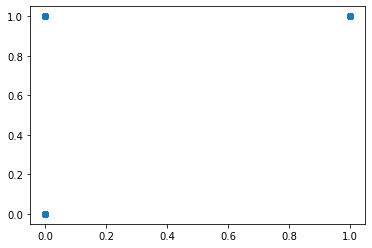

In [63]:
_ = plt.scatter((tmp > 1).astype(int), data[mixed_dict["target"]])

In [64]:
c_mat = confusion_matrix((tmp > 1).astype(int), data[mixed_dict["target"]])

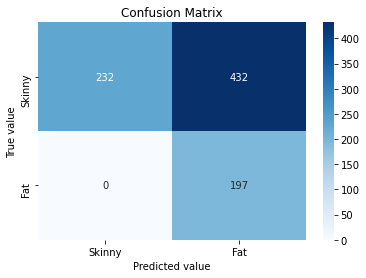

In [65]:
cmap='Blues'
categories=["Skinny", "Fat"]

_ = sns.heatmap(c_mat, 
                annot=True,            
                fmt="",
                cmap=cmap,
#                 cbar=cbar,
                xticklabels=categories,
                yticklabels=categories
               )
_ = plt.title("Confusion Matrix")
# _ = plt.xlabel(f'Predicted value\n\nAccuracy={summary_df["Accuracy"].values[0]}\nSensitivity={summary_df["Sensitivity"].values[0]}\nSpecificity={summary_df["Specificity"].values[0]}\nF1 Score={summary_df["F1"].values[0]}')
_ = plt.xlabel(f'Predicted value')
_ = plt.ylabel("True value")

In [ ]:
stop!

## With the fitted model attempt to predict the test data

In [ ]:
y_pred = reg.predict(df_test.filter(regex="feat"))
y_pred.head(2)

In [ ]:
y_test = df_test[["target"]]
y_test.head(2)

## Calculate the r2 between the predicted vs the real scores

In [ ]:
r_sq = r2_score(y_test["target"], 
        y_pred)
r_sq

## Plot the predicted vs the real values

In [ ]:
_ = plt.figure(figsize=(12, 7))
_ = plt.plot(y_test["target"], 
             y_pred, 
             'o', 
#              label='original data'
            )
_ = plt.annotate(text = f"R-squared = {round(r_sq, 3)}",
                 xy=(100, -140),)